In [15]:
!pip install spacy
!pip install nltk
!pip install torch
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     - -------------------------------------- 0.3/5.7 MB 5.2 MB/s eta 0:00:02
     ---- ----------------------------------- 0.7/5.7 MB 9.1 MB/s eta 0:00:01
     ----------- ---------------------------- 1.7/5.7 MB 12.2 MB/s eta 0:00:01
     --------------------- ------------------ 3.1/5.7 MB 16.6 MB/s eta 0:00:01
     ------------------------- -------------- 3.6/5.7 MB 17.8 MB/s eta 0:00:01
     ---------------------------------------  5.7/5.7 MB 20.4 MB/s eta 0:00:01
     ---------------------------------------- 5.7/5.7 MB 20.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ------------------------------------- 536.2/536.2 kB 32.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/192.2 MB ? eta -:--:--
   ---------------------------------------- 0.9/192.2 MB 55.0 MB/s eta 0:00:04
   ---------------------------------------- 2.1/192.2 MB 22.7 MB/s eta 0:00

# Syntactic score functions

## Yes/No question classification

In [16]:
def is_yes_no_question(question):
    question = question.lower().strip()
    #purposely has space after words since it should be a word in itself as part of a sentence
    if question.startswith(('is ', 'are ', 'do ', 'does ', 'did ', 'was ', 'were ', 'will ', 'can ', 'could ', 'should ', 'have ', 'has ', 'had ')): 
        return 1
    else:
        return 0

def is_yes_no_answer(answer):
    answer = answer.lower().strip()
    if answer.startswith(('yes','no')):
        return 1
    else:
        return 0

def evaluate_type_coherency(question,answer):
    if is_yes_no_question(question)==is_yes_no_answer(answer):
        return 1
    else:
        return 0


# Test the function
sentences = [
    "Is this right?",
    "Which questions are you thinking of?",
    "Hassan",
    'Has an'
]

for sentence in sentences:
    is_yes_no = is_yes_no_question(sentence)
    print(f"Sentence: {sentence}")
    print(f"Is yes/no type question: {is_yes_no:.2f}\n")

# Test the function
sentences = [
    "Is this right?",
    "Which questions are you thinking of?",
    "Hassan",
    'Has an',
    'Yes!',
    'No.',
    'Maybe'
]

for sentence in sentences:
    q_is_yes_no = is_yes_no_question(sentence)
    a_is_yes_no = is_yes_no_answer(sentence)
    print(f"Sentence: {sentence}")
    print(f"Is yes/no type question: {q_is_yes_no:.2f}")
    print(f"Is yes/no type answer: {a_is_yes_no:.2f}\n")

Sentence: Is this right?
Is yes/no type question: 1.00

Sentence: Which questions are you thinking of?
Is yes/no type question: 0.00

Sentence: Hassan
Is yes/no type question: 0.00

Sentence: Has an
Is yes/no type question: 1.00

Sentence: Is this right?
Is yes/no type question: 1.00
Is yes/no type answer: 0.00

Sentence: Which questions are you thinking of?
Is yes/no type question: 0.00
Is yes/no type answer: 0.00

Sentence: Hassan
Is yes/no type question: 0.00
Is yes/no type answer: 0.00

Sentence: Has an
Is yes/no type question: 1.00
Is yes/no type answer: 0.00

Sentence: Yes!
Is yes/no type question: 0.00
Is yes/no type answer: 1.00

Sentence: No.
Is yes/no type question: 0.00
Is yes/no type answer: 1.00

Sentence: Maybe
Is yes/no type question: 0.00
Is yes/no type answer: 0.00



## Conciseness

In [17]:
import spacy
from nltk.tokenize import word_tokenize
import numpy as np

# Load the spaCy model for linguistic features
nlp = spacy.load("en_core_web_sm")

def evaluate_conciseness(answer, debug=False):
    # Tokenize the answer and analyze with spaCy
    if len(answer)==0: 
        return 0

    doc = nlp(answer)
    word_count = len(word_tokenize(answer))
    punctuation_count = sum(token.pos == spacy.symbols.PUNCT for token in doc)
    relevant_words=np.maximum(1,word_count-punctuation_count)

    # content words NOUN and VERB
    content_words_count = sum(token.pos in [spacy.symbols.NOUN, spacy.symbols.VERB] for token in doc)
    
    # Consider yes/no as content if it is the first token
    first_token_is_yes_no = doc[0].text.lower() in ["yes", "no"]
    if first_token_is_yes_no:
        content_words_count += 1
    
    conciseness_score=content_words_count/relevant_words

    if debug==True:
        print('Answer:', answer)
        print('Word count:',word_count, 
              'Punctuation count', punctuation_count, 
              'Content words count:', content_words_count, 
              'Relevant words:', relevant_words, 
              '|Conciseness score:', conciseness_score)

    return conciseness_score

# Test the function
answers = [
    "Yes.",
    'No no!',
    'Yes, no, maybe so',
    'no it is not',
    "The cat sat on the mat.",
    'The spectacular looking blue cat sat on the beautiful mat looking towards the sky',
    ''
]

for answer in answers:
    score = evaluate_conciseness(answer,debug=True)
    print('')

Answer: Yes.
Word count: 2 Punctuation count 1 Content words count: 1 Relevant words: 1 |Conciseness score: 1.0

Answer: No no!
Word count: 3 Punctuation count 1 Content words count: 1 Relevant words: 2 |Conciseness score: 0.5

Answer: Yes, no, maybe so
Word count: 6 Punctuation count 2 Content words count: 1 Relevant words: 4 |Conciseness score: 0.25

Answer: no it is not
Word count: 4 Punctuation count 0 Content words count: 1 Relevant words: 4 |Conciseness score: 0.25

Answer: The cat sat on the mat.
Word count: 7 Punctuation count 1 Content words count: 3 Relevant words: 6 |Conciseness score: 0.5

Answer: The spectacular looking blue cat sat on the beautiful mat looking towards the sky
Word count: 14 Punctuation count 0 Content words count: 6 Relevant words: 14 |Conciseness score: 0.42857142857142855




## Fluency

In [18]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def evaluate_syntax_fluency(sentence, debug=False):
    doc = nlp(sentence)

    if len(doc)==0:
        return 0
    
    # Heuristics for scoring
    score = 0
    max_score = 5  # Total number of checks

    # Check 1: Sentence has a verb  
    has_verb = any(token.pos_ == "VERB" for token in doc)
    score += 1 if has_verb else 0

    # Check 2: Sentence has a nominal subject  
    has_subject = any(token.dep_ == "nsubj" or token.dep_ == "nsubjpass" for token in doc)
    score += 1 if has_subject else 0

    # Check 3: Reasonable sentence length (not too long or too short)
    # Assuming a sentence should typically be between 3 and 20 words for simplicity
    has_reasonable_length = 1 if 3 <= len(doc) <= 20 else 0
    score += has_reasonable_length

    # Check 4: Variety in sentence structure (using different parts of speech)
    unique_pos = len(set(token.pos_ for token in doc))
    if unique_pos >= 4:  # Arbitrary threshold for variety
        score += 1

    # Check 5: Coherence in dependency structure (root should be a verb or an auxiliary verb)
    has_coherent_structure = doc[0].dep_ == "ROOT" and doc[0].pos_ in ["VERB", "AUX"]
    score += 1 if has_coherent_structure else 0

    # Calculate final score
    fluency_score = score / max_score

    if debug==True:
        print(
        'Sentence', sentence, '\n',
        'Has verb:',has_verb, 
        '|Has subject:', has_subject, 
        '|Reasonable length:', has_reasonable_length, 
        '|Unique POS:', unique_pos, 
        '|Coherent structure:',has_coherent_structure,
        '||Fluency score:', fluency_score
        )

    return fluency_score

# Test the function
sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "The fox jumped over the dog.",
    "Running fast.",
    "Incomprehensible fragment lacking verb",
    "The",
    "Excessively lengthy sentence with a lot of redundant and unnecessary words causing it to be overly verbose and lose coherence.",
    'Yes'
]

for sentence in sentences:
    score = evaluate_syntax_fluency(sentence, debug=True)


Sentence The quick brown fox jumps over the lazy dog. 
 Has verb: True |Has subject: True |Reasonable length: 1 |Unique POS: 6 |Coherent structure: False ||Fluency score: 0.8
Sentence The fox jumped over the dog. 
 Has verb: True |Has subject: True |Reasonable length: 1 |Unique POS: 5 |Coherent structure: False ||Fluency score: 0.8
Sentence Running fast. 
 Has verb: True |Has subject: False |Reasonable length: 1 |Unique POS: 3 |Coherent structure: True ||Fluency score: 0.6
Sentence Incomprehensible fragment lacking verb 
 Has verb: False |Has subject: True |Reasonable length: 1 |Unique POS: 2 |Coherent structure: False ||Fluency score: 0.4
Sentence The 
 Has verb: False |Has subject: False |Reasonable length: 0 |Unique POS: 1 |Coherent structure: False ||Fluency score: 0.0
Sentence Excessively lengthy sentence with a lot of redundant and unnecessary words causing it to be overly verbose and lose coherence. 
 Has verb: True |Has subject: True |Reasonable length: 0 |Unique POS: 11 |Coher

## Syntactic score

In [19]:
def syntactic_score(question, answer, weights_IS_yes_no=[3,2,2], weights_NOT_yes_no=[1,2,3], debug=False, extra_outputs='False'):
    
    #only question and answer are strictly required. Others are set to default values of equal weights, no print out and no additional outputs
    #There are 2 sets of weights since answers to YES/NO type questions are not comparable to non Yes/No type
    #weights are of [0] coherency, [1] conciseness and [2] fluency are proportions which are scaled to 0 and 1 within the function. 
    
    # Default values have the following logic:
    # if IS a Yes/No type, then fluency is less relevant since short answers are generally not fluent. Better answers should be coherent first and concise second, thus weights_IS_yes_no=[3,2,1]
    # if NOT a Yes/No type, then fluency is deemed more important than conciseness. Coherency in this case represents answering in the "wrong format", thus weights_NOT_yes_no=[1,2,3]
    

    is_yes_no_type=is_yes_no_question(question)
    coherency = evaluate_type_coherency(question,answer)
    conciseness=evaluate_conciseness(answer)
    fluency=evaluate_syntax_fluency(answer)
    
    #choose adequate weights for the case
    if is_yes_no_type==1:
        weights=weights_IS_yes_no   
    else:
        weights=weights_NOT_yes_no   

    #calulate score as weighted average
    syntactic_score=(coherency*weights[0]+conciseness*weights[1]+fluency*weights[2])/np.sum(weights)

    #print out for debug
    if debug==True:
        print('Q:',question,
              '|YES/NO TYPE:',is_yes_no_type, 
              '||A:',answer,
              '|COHERENCY(',weights[0],'):',coherency, 
              '|CONCISENESS(',weights[1],'):',conciseness,
              '|FLUENCY(',weights[2],'):', fluency, 
              '||SYNTACTIC SCORE:',syntactic_score
               ) 
    
    #return outputs
    if extra_outputs==True:
        return syntactic_score, is_yes_no_type, coherency, fluency, conciseness
    else:
        return syntactic_score

In [20]:
# Examples putting it all together
questions=['Are dogs pets?',  
           'Is a dog a pet?',
           'Is your dog a pet?',
           'A pet is a dog?',

           'Is it Saturday?',  
           'Is it Saturday today?',  
           'Is today Saturday',
           'Not a question'
           ]

answers=['I dont know',
         'Yes it is',
         'Yes!',
         'A pet it is',

         'It is not Saturday',
         'No',
         'Saturday it is not',
         'The'

        ]

# Test the function
for i in range(len(questions)):
    syntactic_score_=syntactic_score(questions[i],answers[i],debug=True)

Q: Are dogs pets? |YES/NO TYPE: 1 ||A: I dont know |COHERENCY( 3 ): 0 |CONCISENESS( 2 ): 0.3333333333333333 |FLUENCY( 2 ): 0.8 ||SYNTACTIC SCORE: 0.3238095238095238
Q: Is a dog a pet? |YES/NO TYPE: 1 ||A: Yes it is |COHERENCY( 3 ): 1 |CONCISENESS( 2 ): 0.3333333333333333 |FLUENCY( 2 ): 0.4 ||SYNTACTIC SCORE: 0.6380952380952382
Q: Is your dog a pet? |YES/NO TYPE: 1 ||A: Yes! |COHERENCY( 3 ): 1 |CONCISENESS( 2 ): 1.0 |FLUENCY( 2 ): 0.0 ||SYNTACTIC SCORE: 0.7142857142857143
Q: A pet is a dog? |YES/NO TYPE: 0 ||A: A pet it is |COHERENCY( 1 ): 1 |CONCISENESS( 2 ): 0.25 |FLUENCY( 3 ): 0.6 ||SYNTACTIC SCORE: 0.5499999999999999
Q: Is it Saturday? |YES/NO TYPE: 1 ||A: It is not Saturday |COHERENCY( 3 ): 0 |CONCISENESS( 2 ): 0.0 |FLUENCY( 2 ): 0.6 ||SYNTACTIC SCORE: 0.17142857142857143
Q: Is it Saturday today? |YES/NO TYPE: 1 ||A: No |COHERENCY( 3 ): 1 |CONCISENESS( 2 ): 1.0 |FLUENCY( 2 ): 0.0 ||SYNTACTIC SCORE: 0.7142857142857143
Q: Is today Saturday |YES/NO TYPE: 1 ||A: Saturday it is not |COH

# QA Dataset application

## Dataloader

In [21]:
# Change to appropriate local file path
%cd '/content/drive/MyDrive/2023-FALL/11-611 NLP/NLP Project Ideas'

[WinError 3] The system cannot find the path specified: "'/content/drive/MyDrive/2023-FALL/11-611 NLP/NLP Project Ideas'"
h:\My Drive\2023-FALL\11-611 NLP\Project


In [22]:

import torch
from torch.utils.data import Dataset
import os
import numpy as np


class CustomData(Dataset):

    def __init__(self, file_dir):
        self.file = file_dir
        self.article_name = []
        self.questions = []
        self.answers = []
        self.q_diffi = []
        self.a_diffi = []
        self.article_path = []
        self.context = {} # only fill when load the dataset

        # get question answer pairs
        for div in ['S08', 'S09', 'S10']:
          skip = True
          qa_path = os.path.join(self.file, div, "question_answer_pairs.txt")
          with open(qa_path, 'rb') as f:
            for line in f:
              if skip:
                skip = False
                continue
              try:
                row = line.decode().split('\t')
              except:
                continue
              # print(row)
              if "NULL" in row:
                continue # if any feature does not exist -> skip
              self.article_name.append(row[0])
              self.questions.append(row[1])
              self.answers.append(row[2])
              self.q_diffi.append(row[3])
              self.a_diffi.append(row[4])
              self.article_path.append(div + "/"+ row[5][:-1]) # get rid of '\n

        print("length of dataset: ", len(self.questions))


    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):

        # retrieve context here -> less mem storage overhead
        try:
          curr_context = self.context[self.article_name[idx]]
        except KeyError:
          context_file = self.file + "/" + self.article_path[idx] + ".txt"
          # read all content, including the related items
          with open(context_file, 'rb') as f:
            curr_context = f.read().decode().replace('\n',' ')
          self.context[self.article_name[idx]] = curr_context

        #return self.questions[idx], self.answers[idx], curr_context
        return (self.article_name[idx],
                self.questions[idx],
                self.answers[idx],
                self.q_diffi[idx],
                self.a_diffi[idx],
                self.article_path[idx],
                curr_context
                )


In [23]:
# Load data using CustomData function
data_path = 'Question_Answer_Dataset_v1.2'
dataset = CustomData(data_path)
# Print random set for data exploration
n=len(dataset)
n_show=1

rand_range=np.random.randint(0,n,n_show)

for line in rand_range:
  print('line:',line)
  print("article_name: ", dataset.article_name[line])
  print("question: ", dataset.questions[line])
  print("answer: ", dataset.answers[line])
  print("q_diffi: ", dataset.q_diffi[line])
  print("a_diffi: ", dataset.a_diffi[line])
  print("article_path: ", dataset.article_path[line])
  print("article: ", dataset[line][6])
  print('\n')

length of dataset:  2725
line: 966
article_name:  Theodore_Roosevelt
question:  Did Theodore Roosevelt go to Harvard?
answer:  Yes
q_diffi:  easy
a_diffi:  medium
article_path:  S08/data/set3/a7
article:  Theodore Roosevelt    Theodore Roosevelt, Jr. ( ; October 27 1858   January 6 1919), also known as T.R., and to the public (but never to friends and intimates) as Teddy, was the twenty-sixth President of the United States, and a leader of the Republican Party and of the Progressive Movement.   He became the youngest President in United States history at the age of 42. He served in many roles including Governor of New York, historian, naturalist, explorer, author, and soldier. Roosevelt is most famous for his personality: his energy, his vast range of interests and achievements, his model of masculinity, and his "cowboy" persona. His last name, often mispronounced, is, per Roosevelt, "pronounced as if it were spelled 'Rosavelt', in three syllables, the first syllable as if it was 'Rose

## Syntactic score application

In [24]:
import random

#make random selection
n=len(dataset) #n=500 #random sample to get from len(dataset)  
#random_select=random.sample(range(len(dataset)), n) #Sometime fails because of UTF 

In [25]:
# Get scores
scores=[]
for line in range(n): #random_select: 
    q=dataset.questions[line]
    a=dataset.answers[line]
   
    scores.append(syntactic_score(q, #question
                                  a, #answer
                                  #weights_IS_yes_no=[1,0,1], #weights of coherency, fluency and conciseness in case of Yes/No type question
                                  #weights_NOT_yes_no=[1,3,2], #weights of coherency, fluency and conciseness in case of NOT Yes/No type question
                                  debug=False, #print out for debugging
                                  extra_outputs=True) #output syntactic score, coherency, fluency, conciseness (last 3 are the 'extra')
                                  ) 



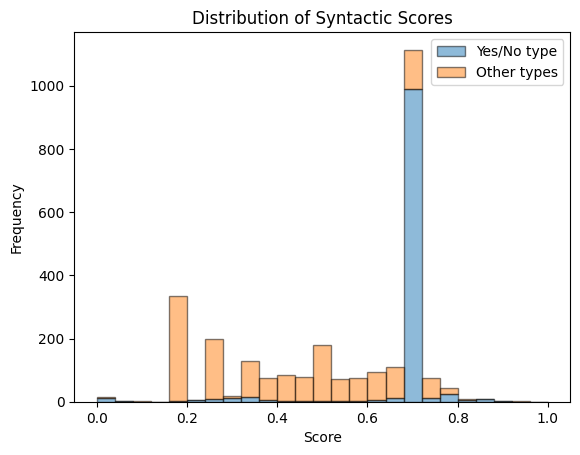

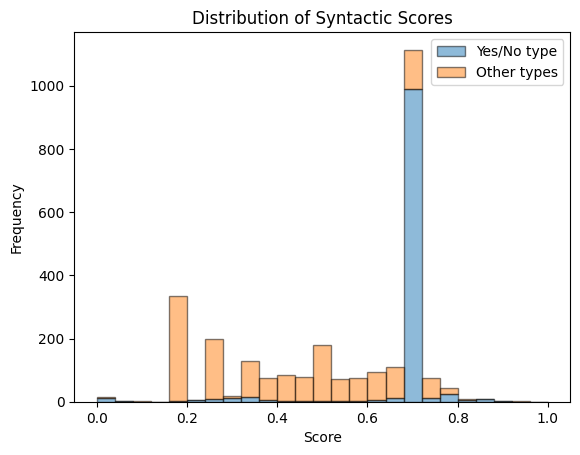

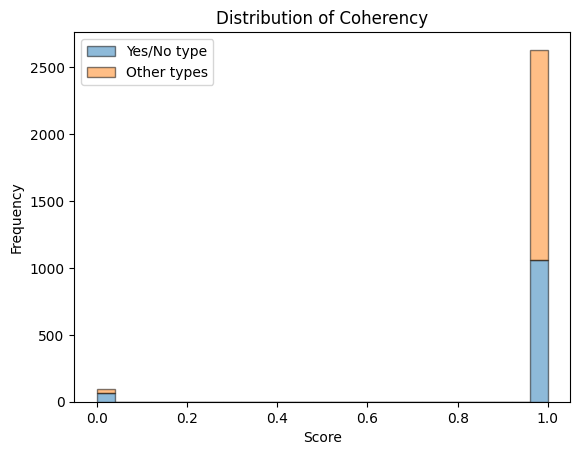

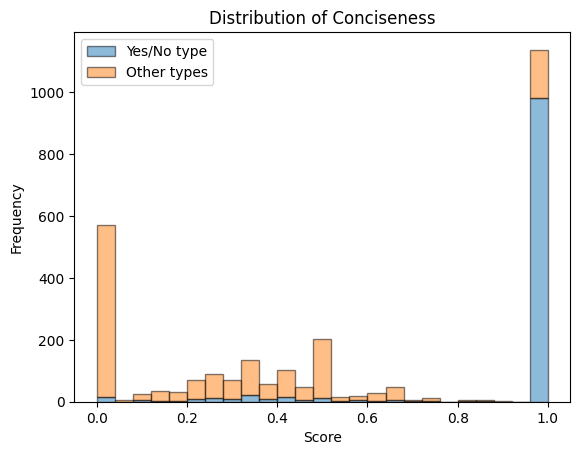

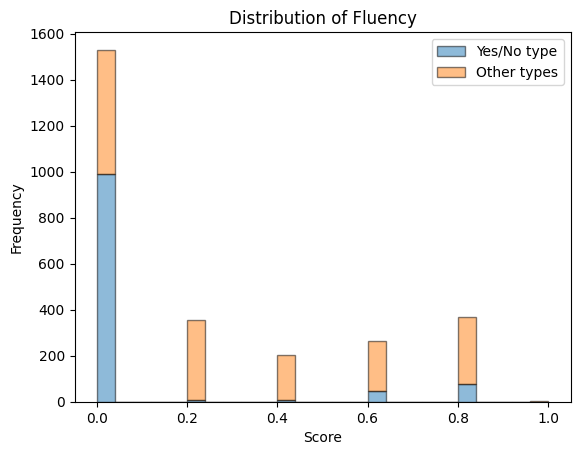

In [26]:
import numpy as np
import matplotlib.pyplot as plt

scores = np.array(scores)
ind_yn = scores[:,1] == 1  # Yes/No type

# Histogram of Syntactic Score
plt.hist([scores[ind_yn,0], scores[~ind_yn,0]], bins=25, range=(0,1), edgecolor='black', alpha=0.5, stacked=True, label=['Yes/No type', 'Other types'])
plt.title('Distribution of Syntactic Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.grid(True)
plt.legend()
plt.show()


# Histogram of Syntactic Score
plt.hist([scores[ind_yn,0], scores[~ind_yn,0]], bins=25, range=(0,1), edgecolor='black', alpha=0.5, stacked=True, label=['Yes/No type', 'Other types'])
plt.title('Distribution of Syntactic Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.grid(True)
plt.legend()
plt.show()

# Histogram of Coherency
plt.hist([scores[ind_yn,2], scores[~ind_yn,2]], bins=25, range=(0,1), edgecolor='black', alpha=0.5, stacked=True, label=['Yes/No type', 'Other types'])
plt.title('Distribution of Coherency')
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.grid(True)
plt.legend()
plt.show()

# Histogram of Conciseness
plt.hist([scores[ind_yn,4], scores[~ind_yn,4]], bins=25, range=(0,1), edgecolor='black', alpha=0.5, stacked=True, label=['Yes/No type', 'Other types'])
plt.title('Distribution of Conciseness')
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.grid(True)
plt.legend()
plt.show()

# Histogram of Fluency
plt.hist([scores[ind_yn,3], scores[~ind_yn,3]], bins=25, range=(0,1), edgecolor='black', alpha=0.5, stacked=True, label=['Yes/No type', 'Other types'])
plt.title('Distribution of Fluency')
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.grid(True)
plt.legend()
plt.show()


In [42]:
# evaluation of question and answer match

n=len(dataset)
q_yes=0
a_yes=0
match_y=0
match_n=0
for line in range(n):

    q_y=is_yes_no_question(dataset.questions[line]) 
    a_y=is_yes_no_answer(dataset.answers[line])

    #print(dataset.questions[line],'|', q_y,'|', dataset.answers[line],'|', a_y) #output used for word distribution analysis
    q_yes+=q_y
    a_yes+=a_y
    match_y+=q_y*a_y
    match_n+=(1-q_y)*(1-a_y)

print('N question-answer pairs:',n)
print('N Questions that are Polar (Y/N type):',q_yes)
print('Answers that are Polar (Y/N type)', a_yes)
print('Coherency match of Polar:', match_y, '|ratio to polar questions:',match_y/q_yes)
print('Coherency match of Non-Polar', match_n,'|ratio to non-polar questions:', match_n/(n-q_yes))

print('Total Match ratio:',(match_y+match_n)/n)

N question-answer pairs: 2725
N Questions that are Polar (Y/N type): 1126
Answers that are Polar (Y/N type) 1093
Coherency match of Polar: 1062 |ratio to polar questions: 0.9431616341030196
Coherency match of Non-Polar 1568 |ratio to non-polar questions: 0.9806128830519074
Total Match ratio: 0.9651376146788991
